In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

# LST paired sites prepare

In [2]:
lst=read_img(spei_path+'lst_1516_afr_001.tif')[0]
lst=lst*0.02-273.15
print("lst:",lst.min(),lst.max())
lst[lst==0]=np.nan

lst: nan nan


In [3]:
treeH = read_img(spei_path+'African_th2019_001_230525.tif')[0]
print("treeH:",treeH.min(),treeH.max())
tc_planet = read_img(spei_path+'Africa_tc2019_mosaic_001_fillNaN_231215.tif')[0]
print("tc_planet:",tc_planet.min(),tc_planet.max())
treeH[treeH==0]=np.nan
tc_planet=tc_planet.astype(np.float32)
tc_planet[tc_planet==0]=np.nan
tc_planet[tc_planet>100]=np.nan
ndvi_res=read_img(spei_path+'ndvi_resistance_230321.tif')[0]
csif_res=read_img(spei_path+'csif_resistance_230321.tif')[0]
ndvi_res[ndvi_res==0]=np.nan
csif_res[csif_res==0]=np.nan
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

treeH: 0.0 37.440773
tc_planet: 0 216


In [4]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [5]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#forest_mask*
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

## slide window

In [6]:
"""
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

dist_pool1=[DEAA*mask,DAA*mask] #2015 drought,[elephant,non-elephant] ###use lst15 ###简写d15
dist_name1=['DEAA','DAA']

res_pool1=[treeH,tc_planet,lst,ndvi_res,csif_res,dem,slope]
res_name1=['treeH','tc_planet','lst','ndvi_res','csif_res','dem','slope']

aa=[]
aa_name=[]
for i in range(2):
    for j in range(7):
        el=[25,dist_pool1[i],res_pool1[j]]
        aa.append(el)
        aa_name.append('Correlation_{}_{}_0.25deg_240506.npy'.format(dist_name1[i],res_name1[j]))
print(aa_name)

['Correlation_DEAA_treeH_0.25deg_240506.npy', 'Correlation_DEAA_tc_planet_0.25deg_240506.npy', 'Correlation_DEAA_lst_0.25deg_240506.npy', 'Correlation_DEAA_ndvi_res_0.25deg_240506.npy', 'Correlation_DEAA_csif_res_0.25deg_240506.npy', 'Correlation_DEAA_dem_0.25deg_240506.npy', 'Correlation_DEAA_slope_0.25deg_240506.npy', 'Correlation_DAA_treeH_0.25deg_240506.npy', 'Correlation_DAA_tc_planet_0.25deg_240506.npy', 'Correlation_DAA_lst_0.25deg_240506.npy', 'Correlation_DAA_ndvi_res_0.25deg_240506.npy', 'Correlation_DAA_csif_res_0.25deg_240506.npy', 'Correlation_DAA_dem_0.25deg_240506.npy', 'Correlation_DAA_slope_0.25deg_240506.npy']


In [8]:
for i in range(14):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(spei_path+aa_name[i],kk)

执行任务0 (34856)...
执行任务1 (34856)...
执行任务2 (34856)...
执行任务3 (34856)...
执行任务4 (34856)...
执行任务5 (34856)...
执行任务6 (34856)...
执行任务7 (34856)...
执行任务8 (34856)...
执行任务9 (34856)...
执行任务10 (34856)...
执行任务11 (34856)...
执行任务12 (34856)...
执行任务13 (34856)...


## 成对样点求Δ

In [2]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'Correlation_DEAA_dem_0.25deg_240506.npy',allow_pickle=True)
dem2=np.load(spei_path+'Correlation_DAA_dem_0.25deg_240506.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Correlation_DEAA_slope_0.25deg_240506.npy',allow_pickle=True)
slo2=np.load(spei_path+'Correlation_DAA_slope_0.25deg_240506.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [3]:
res_name=['treeH','tc_planet','lst']
delta=[]
for i in range(3):
    f1=np.load(spei_path+'Correlation_DEAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Correlation_DAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(260, 316)

In [4]:
# 每一层数据位置对应,建立mask,使得每一层有效数值位置对应
dd=np.copy(delta)
dd[~np.isnan(dd)]=1
cc_mask=np.ones((260,316))
for i in range(3):
    cc_mask=cc_mask*dd[i]

delta_dd=np.copy(delta)
for i in range(3):
    delta_dd[i]=delta[i]*cc_mask
    print(np.count_nonzero(~np.isnan(delta_dd[i])))

2705
2705
2705


In [5]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

tree_delta=[]
for i in range(3):
    tree_delta.append(kill_nan(delta_dd[i]))

In [6]:
mean=[]
for i in range(3):
    mean.append(np.mean(tree_delta[i]))
mean

[1.1824275212730806, 3.5182778763021867, -0.23762718172478808]

# LST vs forest strucutre

In [7]:
#['treeH','tc','lst']
del_tree=[tree_delta[0],tree_delta[1]]
std0=np.std(del_tree[0])
std1=np.std(del_tree[1])
std0,std1

(3.827159864059404, 13.98450099826185)

In [8]:
del_lst=tree_delta[2]

4.326041963799175e-177
3.0959494494153624e-250


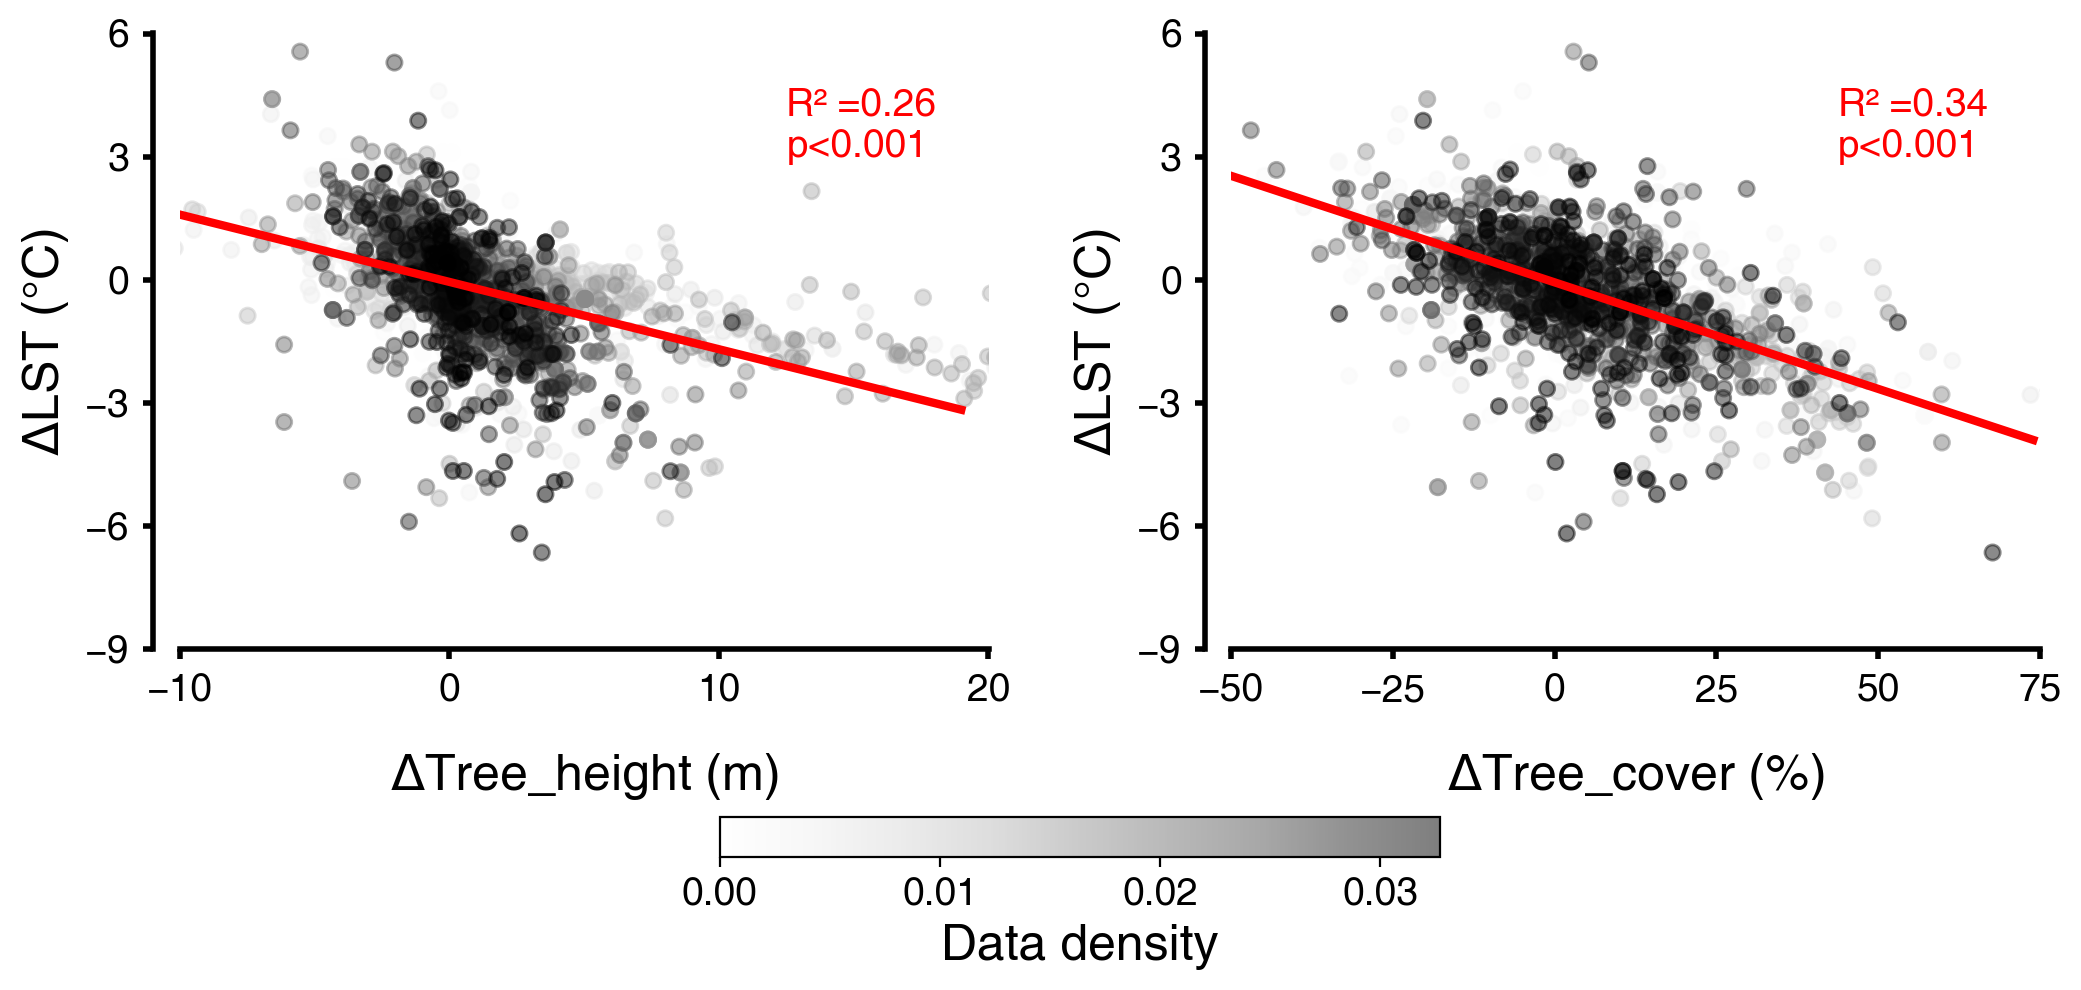

In [9]:
import scipy
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from matplotlib.gridspec import GridSpec     # 利用网格确定图形的位置


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.3,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl=['red','blue']
mark=['*','.']
x_s1=np.arange(-10,20)
x_s2=np.arange(-50,75)
x_s=[x_s1,x_s2]
#cl=[(23/255,177/255,235/255),(236/255,25/255,32/255)]
cl1 = np.array([(82,160,134),(244,132,102)])
cl=cl1/255

for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    xy=np.vstack([del_tree[i],del_lst])
    z=gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = np.array(del_tree[i])[idx], np.array(del_lst)[idx], z[idx]
    linear_model=np.polyfit(del_tree[i],del_lst,1)
    func=np.poly1d(linear_model)
    #print(func)
    correlation=np.corrcoef(del_tree[i],del_lst)
    cor,p_value = scipy.stats.pearsonr(del_tree[i],del_lst)
    print(p_value)
    #r2=r2_score(del_tree[i],del_lst)
    #print(r2)
    #print(corr[0][1])
    im=ax.scatter(del_tree[i],del_lst,c=z,alpha=0.5,s=30,cmap='Greys')
    ax.plot(x_s[i],func(x_s[i]),color='red',lw=3)
    #ax.text(0.8,0.88,'p = ' '{:.3f}'.format(p_value), transform = ax.transAxes,color=cl[i])
    ax.text(0.75,0.8,'R\u00b2 ' '={:.2f} \np<0.001'.format(correlation[0][1]*correlation[0][1]), transform = ax.transAxes,color='red')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-9,6.01)
    ax.set_yticks(np.arange(-9,6.01,3))
    if i ==0:
        ax.set_xlim(-10,20.01)
        ax.set_xticks(np.arange(-10,20.01,10))
        #ax.spines['left'].set_visible(False)
        #ax.axes.yaxis.set_visible(False)
        ax.set_xlabel('$Δ$Tree_height (m)',size=18,labelpad=15)
        ax.set_ylabel('$Δ$LST (°C)',size=18,labelpad=5)
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-11))
        ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
        #ax.set_xlim(-10,20)
    if i==1:
        ax.set_xlim(-50,75.01)
        ax.set_xticks(np.arange(-50,75.01,25))
        #ax.spines['left'].set_visible(False)
        ax.set_xlabel('$Δ$Tree_cover (%)',size=18,labelpad=15)
        ax.set_ylabel('$Δ$LST (°C)',size=18,labelpad=5)
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-54))
        ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
        
        position=fig.add_axes([0.35,-0.15,0.3,0.05])#左、底、宽、高
        cbar = fig.colorbar(im,orientation='horizontal',cax=position)#,ticks=np.linspace(0, 1.5, 4)
        cbar.set_ticks(np.arange(0,0.031,0.01))
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(label='Data density',size=18)
        
    ax.xaxis.set_tick_params(width=2,labelsize=14,pad=5)
    ax.yaxis.set_tick_params(width=2,labelsize=14,pad=5)
    ax.spines['bottom'].set_linewidth(2);####设置左边坐标轴的粗细
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_e-f.tif", dpi=600, bbox_inches = 'tight')


# LST vs resistance

In [15]:
res_name=['ndvi_res','csif_res','lst']
delta=[]
for i in range(3):
    f1=np.load(spei_path+'Correlation_DEAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Correlation_DAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(260, 316)

In [16]:
pp_value=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.load(spei_path+'Correlation_DEAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Correlation_DAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value.append(p)
pp_value #p value of ndvi_res and csif_res

[2.9112319829711706e-06, 1.246043302004176e-07]

In [17]:
# 每一层数据位置对应,建立mask,使得每一层有效数值位置对应
dd=np.copy(delta)
dd[~np.isnan(dd)]=1
cc_mask=np.ones((260,316))
for i in range(3):
    cc_mask=cc_mask*dd[i]

delta_dd=np.copy(delta)
for i in range(3):
    delta_dd[i]=delta[i]*cc_mask
    print(np.count_nonzero(~np.isnan(delta_dd[i])))

2921
2921
2921


In [19]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(3):
    res_delta.append(kill_nan(delta_dd[i]))

In [20]:
mean=[]
for i in range(3):
    mean.append(np.mean(res_delta[i]))
mean

[0.0028914752499529127, 0.0063168603196122886, -0.23002707831706956]

In [21]:
del_lst=res_delta[2]

1.3038794346222335e-40 -0.04500483669673083
1.2112059687302825e-22 -0.050906853631530025


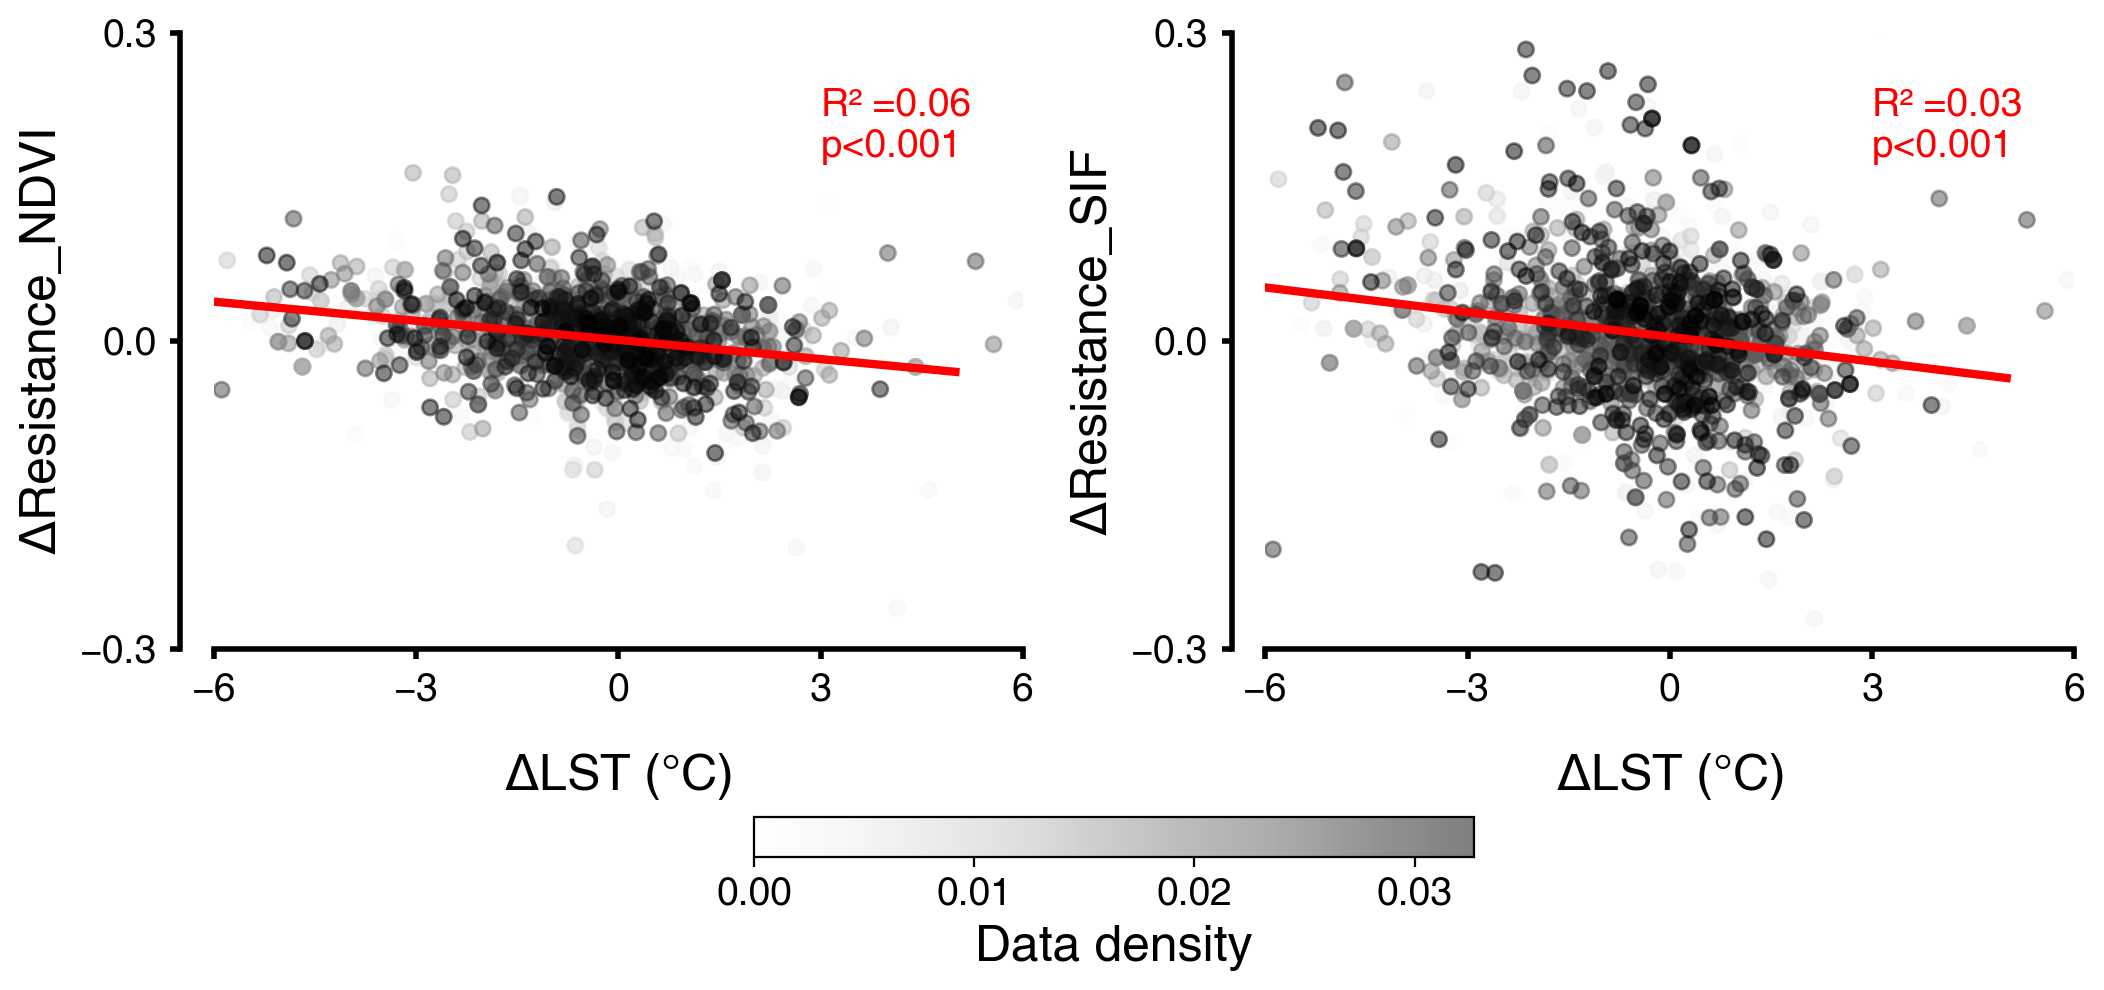

In [22]:
import scipy
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from matplotlib.gridspec import GridSpec     # 利用网格确定图形的位置


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.3,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl=['red','blue']
mark=['*','.']
x_s1=np.arange(-6,6)
x_s2=np.arange(-6,6)
x_s=[x_s1,x_s2]
cl=['salmon','C0']

for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    xy=np.vstack([del_lst,res_delta[i]])
    z=gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = np.array(del_lst)[idx],np.array(res_delta)[i][idx], z[idx]
    linear_model=np.polyfit(del_lst,res_delta[i],1)
    func=np.poly1d(linear_model)
    #print(func)
    correlation=np.corrcoef(del_lst,res_delta[i])
    cor,p_value = scipy.stats.pearsonr(del_lst,res_delta[i])
    r2=r2_score(del_lst,res_delta[i])
    print(p_value,r2)
    ax.scatter(del_lst,res_delta[i],c=z,alpha=0.5,s=30,cmap='Greys')
    ax.plot(x_s[i],func(x_s[i]),color='red',lw=3)
    #ax.text(0.8,0.88,'p = ' '{:.3f}'.format(p_value), transform = ax.transAxes,color=cl[i])
    ax.text(0.75,0.8,'R\u00b2 ' '={:.2f} \np<0.001'.format(correlation[0][1]*correlation[0][1]), transform = ax.transAxes,color='red')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-0.3,0.3)
    ax.set_yticks(np.arange(-0.3,0.31,0.3))
    ax.set_xlim(-6,6)
    ax.set_xticks(np.arange(-6,6.01,3))
    if i ==0:
        #ax.spines['left'].set_visible(False)
        #ax.axes.yaxis.set_visible(False)
        ax.set_xlabel('$Δ$LST (°C)',size=18,labelpad=15)
        ax.set_ylabel('$Δ$Resistance_NDVI',size=18,labelpad=5)
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-6.5))
        ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
        #ax.set_xlim(-10,20)
    if i==1:
        #ax.set_xlim(-6,6)
        #ax.set_xticks(np.arange(-6,6.01,3))
        #ax.spines['left'].set_visible(False)
        ax.set_xlabel('$Δ$LST (°C)',size=18,labelpad=15)
        ax.set_ylabel('$Δ$Resistance_SIF',size=18,labelpad=5)
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-6.5))
        ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
        
        position=fig.add_axes([0.35,-0.15,0.3,0.05])#左、底、宽、高
        cbar = fig.colorbar(im,orientation='horizontal',cax=position)#,ticks=np.linspace(0, 1.5, 4)
        cbar.set_ticks(np.arange(0,0.031,0.01))
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(label='Data density',size=18)
    ax.xaxis.set_tick_params(width=2,labelsize=14,pad=5)
    ax.yaxis.set_tick_params(width=2,labelsize=14,pad=5)
    ax.spines['bottom'].set_linewidth(2);####设置左边坐标轴的粗细
